# Neural Network for Package Classification

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Class

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

## Load Data

In [3]:
# Load the CSV file
data = pd.read_csv("PATH/packages2.csv", header=None)
# Define column names
column_names = ['x', 'y', 'ratio', 'area', 'label']

# Assign column names to the DataFrame
data.columns = column_names

#shuffle data to make the training and validation sets more balanced
data = data.sample(frac=1, random_state=42)

# Separate features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values
batch_size = 128

# Split the data into train, validation, and test sets
features_train, features_temp, labels_train, labels_temp = train_test_split(features, labels, test_size=0.2, random_state=42)
features_val, features_test, labels_val, labels_test = train_test_split(features_temp, labels_temp, test_size=0.5, random_state=42)

# Standardize features for train, validation, and test sets separately
scaler_train = StandardScaler()
features_train = scaler_train.fit_transform(features_train)
features_val = scaler_train.transform(features_val)
features_test = scaler_train.transform(features_test)

# Convert class labels to start from 0
labels_train_adjusted = labels_train - 1
labels_val_adjusted = labels_val - 1
labels_test_adjusted = labels_test - 1

# Convert features and labels for train, validation, and test sets to PyTorch tensors
features_train_tensor = torch.tensor(features_train, dtype=torch.float32, device=device)
labels_train_tensor = torch.tensor(labels_train_adjusted, dtype=torch.long, device=device)
features_val_tensor = torch.tensor(features_val, dtype=torch.float32, device=device)
labels_val_tensor = torch.tensor(labels_val_adjusted, dtype=torch.long, device=device)
features_test_tensor = torch.tensor(features_test, dtype=torch.float32, device=device)
labels_test_tensor = torch.tensor(labels_test_adjusted, dtype=torch.long, device=device)

# Create datasets for train, validation, and test sets
train_dataset = CustomDataset(list(zip(features_train_tensor, labels_train_tensor)))
val_dataset = CustomDataset(list(zip(features_val_tensor, labels_val_tensor)))
test_dataset = CustomDataset(list(zip(features_test_tensor, labels_test_tensor)))

# Create DataLoaders for train, validation, and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Neural Network

In [4]:
# Define the neural network architecture
class PackageClassifier(nn.Module):
    def __init__(self):
        super(PackageClassifier, self).__init__()
        self.input_size = 4  # Number of input features (box width, box length, area, ratio)
        self.hidden_size = 8
        self.num_classes = 6
        
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_size, self.num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Training

In [5]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 2000
training_losses = []
validation_losses = []
training_losses_timesteps = []

# Create the neural network
model = PackageClassifier()
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs), desc='Training', unit='epoch'):
    model.train()
    total_loss = 0.0
    for inputs, targets in train_dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)  # Accumulate the total loss
    
    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_dataset)
    training_losses.append(average_loss)
    training_losses_timesteps.append(epoch+1)

    # Validation
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            total_val_loss += val_loss.item() * inputs.size(0)
    average_val_loss = total_val_loss / len(val_dataset)
    validation_losses.append(average_val_loss)

# Save the trained model
torch.save(model.state_dict(), 'package_classifier.pth')
print("Model trained and saved.")

Training: 100%|█████████████████████████████████████████████████████████████████| 2000/2000 [01:59<00:00, 16.75epoch/s]

Model trained and saved.


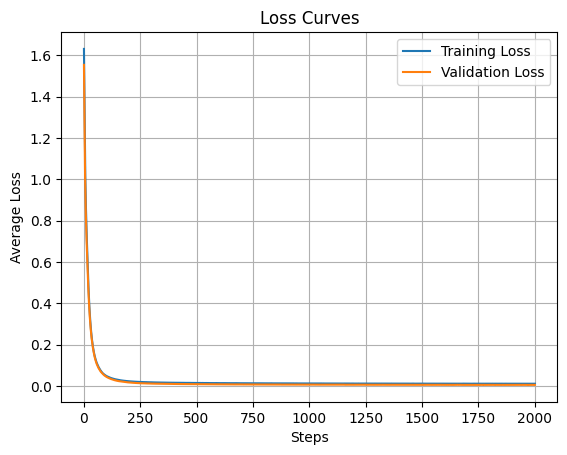

In [7]:
# Plot the losses
plt.plot(training_losses_timesteps, training_losses, label='Training Loss')
plt.plot(training_losses_timesteps, validation_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Average Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

## Compute Accuracy

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Load the saved model
learning_rate = 0.001
model_state_dict = torch.load('package_classifier.pth')
model = PackageClassifier().to(device)

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
model.eval()

# Define loss function (if applicable)
criterion = nn.CrossEntropyLoss()

# Define optimizer (if applicable)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Function to calculate accuracy
def calculate_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

# Iterate over the test dataset
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        # Transfer data to the appropriate device (e.g., GPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Optionally compute loss
        if criterion is not None:
            loss = criterion(outputs, labels)

        # Accumulate predictions and labels for accuracy calculation
        all_predictions.append(outputs)
        all_labels.append(labels)

# Concatenate all predictions and labels
all_predictions = torch.cat(all_predictions, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Calculate accuracy
accuracy = calculate_accuracy(all_predictions, all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 99.82%


In [8]:
# Save the scaler
joblib.dump(scaler_train, 'scaler.pkl')

['scaler.pkl']

# Compute Prediction Probabilities

In [12]:
import torch
import torch.nn.functional as F
import numpy as np

# Assuming your trained model is named 'model'
# Assuming your test data loader is named 'test_loader'

model.eval()  # Set the model to evaluation mode

class_probs = [[] for _ in range(6)]  # Initialize empty list for each class
samples_count = 0

# Iterate over the test data loader
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)  # Assuming you're using GPU, move data to GPU if available
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():  # No need to compute gradients during inference
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)  # Convert raw scores to probabilities

    # Store probabilities for each class
    for i in range(len(labels)):
        class_probs[labels[i]].append(probabilities[i].cpu().numpy())
        samples_count += 1

# Compute mean of probabilities for each class
class_probs_means = [np.mean(prob_list, axis=0) for prob_list in class_probs]

# Now class_probs_means contains the mean predicted probabilities for each class
print(class_probs_means)


[array([1.0000000e+00, 2.4876617e-10, 2.4189249e-17, 8.3234320e-13,
       0.0000000e+00, 0.0000000e+00], dtype=float32), array([1.2982917e-13, 9.9975699e-01, 1.2188306e-09, 4.4370715e-41,
       2.4300214e-04, 1.4272589e-22], dtype=float32), array([1.9634279e-39, 2.1367721e-07, 9.9999982e-01, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), array([6.6108314e-09, 6.2791634e-34, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), array([2.8919960e-20, 2.4321012e-10, 5.6164042e-41, 7.8693034e-29,
       9.9351633e-01, 6.4837039e-03], dtype=float32), array([1.2193823e-29, 2.1766632e-23, 0.0000000e+00, 7.0713110e-36,
       7.6006772e-03, 9.9239945e-01], dtype=float32)]


## Visualize Prediction Probabilities

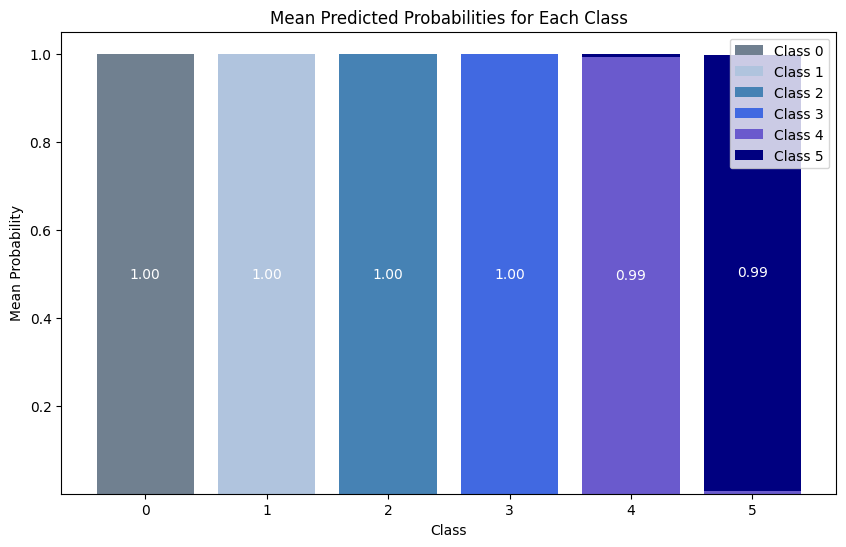

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming class_probs_means is the list of mean predicted probabilities for each class

num_samples = len(class_probs_means)
num_classes = len(class_probs_means[0])

# Set up colors for each class
colors = ['slategrey', 'lightsteelblue', 'steelblue', 'royalblue', 'slateblue', 'navy']

# Plot the mean predicted probabilities for each sample
plt.figure(figsize=(10, 6))
bottom = np.zeros(num_classes)  # Start with zero height bars
for i in range(num_samples):
    bars = plt.bar(np.arange(num_classes), class_probs_means[i], color=colors[i % len(colors)], label=f'Class {i}', bottom=bottom)
    for bar in bars:
        height = bar.get_height()
        index = int(bar.get_x() + bar.get_width() / 2)  # Convert x-coordinate to integer index
        if height > 0.2:
            plt.text(bar.get_x() + bar.get_width() / 2, height / 2 + bottom[index], f'{height:.2f}', ha='center', va='center', color='white')
    bottom += class_probs_means[i]  # Update the bottom for the next set of bars

plt.xlabel('Class')
plt.ylabel('Mean Probability')
plt.title('Mean Predicted Probabilities for Each Class')
plt.xticks(np.arange(num_classes), np.arange(num_classes))
plt.legend()
plt.show()
